# Actividad 2: Random Forest
Construya un modelo de Random Forest para cada una de las cuencas incluidas en el dataset. Encuentre hiperparámetros y un conjunto de variables que permita superar el rendimiento de los modelos de benchmark. Si no logra un mejor modelo, discuta el porqué.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings

base = './data/'

### Escalamiento y Limpieza de datos

In [100]:
data = pd.read_csv("df_rf_HidroCL_3cuencas.csv")

#conversion a tipo fecha
data['date'] = pd.to_datetime(data['date'])
data = data.rename(columns={'caudal_mean_p0d':'observed'}) # y a nombres manejables
print('tipos de datos:')
print(data.dtypes)

data.to_csv('memory.csv')

tipos de datos:
gauge_id                                   int64
date                              datetime64[ns]
pp_f_gfs_pp_mean_b_none_d1_p0d           float64
pp_f_gfs_pp_mean_b_none_d1_p1d           float64
pp_f_gfs_pp_mean_b_none_d1_p2d           float64
                                       ...      
caudal_mean_p1d                          float64
caudal_mean_p2d                          float64
caudal_mean_p3d                          float64
caudal_mean_p4d                          float64
caudal_mask2                             float64
Length: 279, dtype: object


In [101]:
# separamos para comodidad al visualizar, date como index es recomendado por otros programadores
id0_dailyRain = data[data["gauge_id"] == 9127001].drop("gauge_id", axis=1)
id1_dailyRain = data[data["gauge_id"] == 7330001].drop("gauge_id", axis=1)
id2_dailyRain = data[data["gauge_id"] == 4703002].drop("gauge_id", axis=1)

In [102]:
#todos los datos
id0_dailyRain.iloc[:5]

,date,pp_f_gfs_pp_mean_b_none_d1_p0d,pp_f_gfs_pp_mean_b_none_d1_p1d,pp_f_gfs_pp_mean_b_none_d1_p2d,pp_f_gfs_pp_mean_b_none_d1_p3d,pp_f_gfs_pp_mean_b_none_d1_p4d,pp_o_imerg_pp_mean_b_none_d1_m1d,pp_o_imerg_pp_mean_b_none_d1_m2d,pp_o_imerg_pp_mean_b_none_d1_m3d,pp_o_imerg_pp_mean_b_none_d1_m4d,...,caudal_max_p1d,caudal_max_p2d,caudal_max_p3d,caudal_max_p4d,observed,caudal_mean_p1d,caudal_mean_p2d,caudal_mean_p3d,caudal_mean_p4d,caudal_mask2
2,2001-01-04,88.000000,73.000000,67.000000,60.000000,66.000000,0.0,0.0,0.0,0.0,...,5.813001,6.080000,6.344000,6.608000,5.64,5.81,5.93,6.16,6.42,0.0
5,2001-01-05,474.000000,458.666667,414.900000,410.666667,409.666667,0.0,0.0,0.0,0.0,...,5.813001,5.813001,6.080000,6.344000,5.55,5.64,5.81,5.93,6.16,0.0
8,2001-01-06,124.000000,110.000000,95.000000,93.000000,97.000000,0.0,0.0,0.0,0.0,...,5.545999,5.813001,5.813001,6.080000,5.73,5.55,5.64,5.81,5.93,0.0
11,2001-01-07,2866.066667,3065.342857,0.000000,0.000000,0.000000,4.0,0.0,0.0,0.0,...,5.813001,5.545999,5.813001,5.813001,6.16,5.73,5.55,5.64,5.81,0.0
14,2001-01-08,2904.125000,3109.228571,2917.133333,0.000000,0.000000,72.0,4.0,0.0,0.0,...,6.872000,5.813001,5.545999,5.813001,7.78,6.16,5.73,5.55,5.64,0.0


**Se mueve la columna 'observed'**

In [103]:
new_index = 267

columna0 = id0_dailyRain.pop('observed')
id0_dailyRain.insert(new_index, 'observed', columna0)
columna1 = id1_dailyRain.pop('observed')
id1_dailyRain.insert(new_index, 'observed', columna1)
columna2 = id2_dailyRain.pop('observed')
id2_dailyRain.insert(new_index, 'observed', columna2)

**Se eliminan las ultimas 10 columnas para cada río**
para quitar las cuencas

In [104]:
delete_to = -10
id0_dailyRain=id0_dailyRain.iloc[:, :delete_to]
id1_dailyRain=id1_dailyRain.iloc[:, :delete_to]
id2_dailyRain=id2_dailyRain.iloc[:, :delete_to]
id0_dailyRain.columns

Index(['date', 'pp_f_gfs_pp_mean_b_none_d1_p0d',
       'pp_f_gfs_pp_mean_b_none_d1_p1d', 'pp_f_gfs_pp_mean_b_none_d1_p2d',
       'pp_f_gfs_pp_mean_b_none_d1_p3d', 'pp_f_gfs_pp_mean_b_none_d1_p4d',
       'pp_o_imerg_pp_mean_b_none_d1_m1d', 'pp_o_imerg_pp_mean_b_none_d1_m2d',
       'pp_o_imerg_pp_mean_b_none_d1_m3d', 'pp_o_imerg_pp_mean_b_none_d1_m4d',
       ...
       'hi_s_cam_gwr_tot_b_none_c_c', 'idx_s_cam_arcr2_tot_b_none_c_c',
       'hi_o_gww_rs_tot_b_none_d1_m45d', 'top_s_cam_lon_mean_b_none_c_c',
       'top_s_cam_lat_mean_b_none_c_c', 'top_s_cam_lon_none_p_none_c_c',
       'top_s_cam_lat_none_p_none_c_c', 'top_s_dga_lon_none_p_none_c_c',
       'top_s_dga_lat_none_p_none_c_c', 'observed'],
      dtype='object', length=268)

**Se eliminan las filas que contengan datos nulos**

In [105]:
# Datos sin NAN
id0_dailyRain=id0_dailyRain.dropna()
id1_dailyRain=id1_dailyRain.dropna()
id2_dailyRain=id2_dailyRain.dropna()

**Ordenamiento de los datos**

In [106]:
# Convertir la columna de fechas a formato de fecha adecuado si es necesario
id0_dailyRain['date'] = pd.to_datetime(id0_dailyRain['date'])
id1_dailyRain['date'] = pd.to_datetime(id1_dailyRain['date'])
id2_dailyRain['date'] = pd.to_datetime(id2_dailyRain['date'])

# Ordenar los datos por fecha ascendente
id0_dailyRain = id0_dailyRain.sort_values('date')
id1_dailyRain = id1_dailyRain.sort_values('date')
id2_dailyRain = id2_dailyRain.sort_values('date')

date0 = id0_dailyRain['date']
date1 = id1_dailyRain['date']
date2 = id2_dailyRain['date']


# Se eliminan las columnas de fechas
id0_dailyRain=id0_dailyRain.drop('date', axis=1)
id1_dailyRain=id1_dailyRain.drop('date', axis=1)
id2_dailyRain=id2_dailyRain.drop('date', axis=1)


**Escalando los datos usando Min-Max Scaler:**

In [110]:
caudalid0 = id0_dailyRain['observed']
caudalid1 = id1_dailyRain['observed']
caudalid2 = id2_dailyRain['observed']

In [111]:
caracteristicas = id0_dailyRain.columns
indices= id0_dailyRain.index

#Se crea el objeto scaler para aplicar el escalado Min-Max en los datos en un rango de 0 a 1
scaler = MinMaxScaler((0, 1))
#Se ajustan y transforman los datos de entrenamiento con la función fit_transform
df = scaler.fit_transform(id0_dailyRain)
id0_dailyRain = pd.DataFrame(df, columns=caracteristicas , index=indices)

caracteristicas = id1_dailyRain.columns
indices= id1_dailyRain.index
#Se crea el objeto scaler para aplicar el escalado Min-Max en los datos en un rango de 0 a 1
scaler = MinMaxScaler((0, 1))
#Se ajustan y transforman los datos de entrenamiento con la función fit_transform
df = scaler.fit_transform(id1_dailyRain)
id1_dailyRain = pd.DataFrame(df, columns=caracteristicas , index=indices)

caracteristicas = id2_dailyRain.columns
indices= id2_dailyRain.index
#Se crea el objeto scaler para aplicar el escalado Min-Max en los datos en un rango de 0 a 1
scaler = MinMaxScaler((0, 1))
#Se ajustan y transforman los datos de entrenamiento con la función fit_transform
df = scaler.fit_transform(id2_dailyRain)
id2_dailyRain = pd.DataFrame(df, columns=caracteristicas , index=indices)

In [112]:
# se reagregan los caudales
id0_dailyRain['observed'] = caudalid0
id1_dailyRain['observed'] = caudalid1
id2_dailyRain['observed'] = caudalid2

In [113]:
# se reagregan las fechas
id0_dailyRain['date'] = date0
id1_dailyRain['date'] = date1
id2_dailyRain['date'] = date2

In [114]:

id0_dailyRain.to_csv(base+'id0.csv')
id1_dailyRain.to_csv(base+'id1.csv')
id2_dailyRain.to_csv(base+'id2.csv')

### Sección Preparación de Datos Pre Modelo

In [115]:
id0_dailyRain = pd.read_csv(base+'id0.csv', index_col=0)
id1_dailyRain = pd.read_csv(base+'id1.csv', index_col=0)
id2_dailyRain = pd.read_csv(base+'id2.csv', index_col=0)

**Se almacenan las variables dependientes en X y la variable objetivo en Y**

In [53]:
id0_dailyRain=id0_dailyRain.dropna()
id1_dailyRain=id1_dailyRain.dropna()
id2_dailyRain=id2_dailyRain.dropna()

In [54]:
id0_dailyRain_nd=id0_dailyRain.drop('date', axis=1)
id1_dailyRain_nd=id1_dailyRain.drop('date', axis=1)
id2_dailyRain_nd=id2_dailyRain.drop('date', axis=1)

In [55]:
X0=id0_dailyRain_nd.drop('observed', axis=1)
y0=id0_dailyRain_nd['observed']

X1=id1_dailyRain_nd.drop('observed', axis=1)
y1=id1_dailyRain_nd['observed']

X2=id2_dailyRain_nd.drop('observed', axis=1)
y2=id2_dailyRain_nd['observed']

**Se dividen los datos en conjuntos entrenamiento, validación y testeo**

El conjunto de datos para cada río se dividirá en tres conjuntos: entrenamiento, validación y testeo. La división es de 70% para entrenamiento, 15% para validación y 15% para testeo. La división se realizará de manera aleatoria, asegurando que cada conjunto represente adecuadamente la distribución de los datos.

In [56]:
#Se utiliza la función train_test_split para dividir el conjunto de datos en conjuntos de entrenamiento, validación y testeo
X0_train, X0_test_val, y0_train, y0_test_val = train_test_split(X0, y0, test_size=0.3, random_state=42)
X0_val, X0_test, y0_val, y0_test = train_test_split(X0_test_val, y0_test_val, test_size=0.5, random_state=42)
print("Río Muco En Puente Muco:")
print("Proporción de entrenamiento:", round(len(X0_train) / len(X0), 2))
print("Proporción de validación:", round(len(X0_val) / len(X0), 2))
print("Proporción de testeo:", round(len(X0_test) / len(X0), 2))
print("\n")
#Se utiliza la función train_test_split para dividir el conjunto de datos en conjuntos de entrenamiento, validación y testeo
X1_train, X1_test_val, y1_train, y1_test_val = train_test_split(X1, y1, test_size=0.3, random_state=42)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_test_val, y1_test_val, test_size=0.5, random_state=42)
print("Río Perquilauquen En San Manuel:")
print("Proporción de entrenamiento:", round(len(X1_train) / len(X1), 2))
print("Proporción de validación:", round(len(X1_val) / len(X1), 2))
print("Proporción de testeo:", round(len(X1_test) / len(X1), 2))
print("\n")
#Se utiliza la función train_test_split para dividir el conjunto de datos en conjuntos de entrenamiento, validación y testeo
X2_train, X2_test_val, y2_train, y2_test_val = train_test_split(X2, y2, test_size=0.3, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_test_val, y2_test_val, test_size=0.5, random_state=42)
print("Río Choapa En Cuncumen:")
print("Proporción de entrenamiento:", round(len(X2_train) / len(X2), 2))
print("Proporción de validación:", round(len(X2_val) / len(X2), 2))
print("Proporción de testeo:", round(len(X2_test) / len(X2), 2))

Río Muco En Puente Muco:
Proporción de entrenamiento: 0.7
Proporción de validación: 0.15
Proporción de testeo: 0.15


Río Perquilauquen En San Manuel:
Proporción de entrenamiento: 0.7
Proporción de validación: 0.15
Proporción de testeo: 0.15


Río Choapa En Cuncumen:
Proporción de entrenamiento: 0.7
Proporción de validación: 0.15
Proporción de testeo: 0.15


### Modelo Machine Learning

**Se construye el modelo de Random Forest Regression:**

In [57]:
model = RandomForestRegressor(random_state=42)  
#Se construye un objeto RandomForestRegressor() que representa el modelo de regresión de Random Forest

**Se crea el diccionario con los hiperparámetros a ajustar:**

In [33]:
# Se define el diccionario param_grid que contiene las combinaciones de valores de hiperparámetros que se probarán durante la búsqueda.
param_grid = {'n_estimators': [50], 'max_depth': [5, 10], 'min_samples_split': [10, 15], 'min_samples_leaf': [5, 10], 'max_features': ['auto','sqrt','log2']}

Se crea el diccionario con los hiperparámetros a ajustar siendo estos los siguientes:

n_estimators: Indica el número de árboles de decisión que se crearán en el random forest regression.

max_depth: Establece la profundidad máxima permitida para cada árbol en el bosque. Controla la cantidad de divisiones que se realizan en cada árbol y, por lo tanto, el nivel de complejidad del modelo.

min_samples_split: Especifica el número mínimo de muestras requeridas para dividir un nodo interno en un árbol de decisión.

min_samples_leaf: Establece el número mínimo de muestras requeridas en un nodo terminal.

max_feature: Determina la cantidad de características que se considerarán al buscar la mejor división en cada nodo del árbol.

**Se realiza la búsqueda de los mejores hiperparámetros con validación cruzada:**

In [ ]:
grid_search0 = GridSearchCV(estimator=model, param_grid=param_grid, cv=5 ,scoring='r2')
grid_search1 = GridSearchCV(estimator=model, param_grid=param_grid, cv=5 ,scoring='r2')
grid_search2 = GridSearchCV(estimator=model, param_grid=param_grid, cv=5 ,scoring='r2')
#Se utiliza GridSearchCV para realizar una búsqueda exhaustiva de hiperparámetros con validación cruzada y encontrar la mejor combinación de hiperparámetros para el modelo de regresión de Random Forest.

#Dentro del GridSearchCV se utilizan los siguientes parámetros:

#estimator=randomforestreg: Se especifica el estimador base que se utilizará en la búsqueda de hiperparámetros. En este caso, se utiliza el modelo de regresión de Random Forest.

#param_grid=param_grid: Se especifica el diccionario param_grid que contiene las combinaciones de valores para los hiperparámetros que se probarán durante la búsqueda.
#Cada combinación de valores se utilizará para ajustar y evaluar el modelo.

#cv=5: Se especifica el esquema de validación cruzada que se utilizará durante la búsqueda de hiperparámetros. En este caso, se utiliza una validación cruzada de 5 folds.

#scoring='r2': Se especifica la métrica de evaluación que se utilizará para seleccionar el mejor modelo.
#Se utiliza 'r2' que es el coeficiente de determinación (R²).

warnings.filterwarnings("ignore")
grid_search0.fit(X0_train, y0_train)
grid_search1.fit(X1_train, y1_train)
grid_search2.fit(X2_train, y2_train)
#Se utiliza fit para ajustar y evaluar múltiples modelos de de regresión de Random Forest con diferentes combinaciones de hiperparámetros utilizando validación cruzada.

#Se obtienen los mejores hiperparámetros y el mejor modelo
best_params0 = grid_search0.best_params_ #se utiliza best_params_ para obtener los mejores valores hiperparámetros obtenidos de grid_search
best_model0 = grid_search0.best_estimator_ #Se utiliza best_estimator_ para obtener el mejor modelo que se ajuste a los datos utilizando los mejores hiperparámetros.

best_params1 = grid_search1.best_params_ #se utiliza best_params_ para obtener los mejores valores hiperparámetros obtenidos de grid_search
best_model1 = grid_search1.best_estimator_ #Se utiliza best_estimator_ para obtener el mejor modelo que se ajuste a los datos utilizando los mejores hiperparámetros.

best_params2 = grid_search2.best_params_ #se utiliza best_params_ para obtener los mejores valores hiperparámetros obtenidos de grid_search
best_model2 = grid_search2.best_estimator_ #Se utiliza best_estimator_ para obtener el mejor modelo que se ajuste a los datos utilizando los mejores hiperparámetros.

print('Mejores hiperparámetros para el Rio Muco En Puente Muco:', best_params0)
print('Mejores hiperparámetros para el Rio Perquilauquen En San Manuel:', best_params1)
print('Mejores hiperparámetros para el Rio Choapa En Cuncumen:', best_params2)

In [70]:
# Crear los modelos
# para los 3 se dieron los mismos hiperparametros
best_params= {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
best_model0 = RandomForestRegressor(**best_params0)  #Se construye un objeto RandomForestRegressor() que representa el modelo de regresión de Random Forest.
best_model1 = RandomForestRegressor(**best_params1) 
best_model2 = RandomForestRegressor(**best_params2) 

In [71]:
best_model0.fit(X0_train, y0_train)
best_model1.fit(X1_train, y1_train)
best_model2.fit(X2_train, y2_train)

RandomForestRegressor(max_depth=10, max_features='auto', min_samples_leaf=5,
                      min_samples_split=10, n_estimators=50)

Se obtuvo que los mejores hiperparámetros obtenidos utiliza max_depth: 20, min_samples_leaf: 5, min_samples_split: 10, n_estimators: 50 y max_features: 'auto' para los 3 rios.

**Prediccion y evaluación de los conjuntos de testeo, validación y entrenamiento:**

 **Río Muco En Puente Muco:**

In [83]:
predictions_test = best_model0.predict(X0_test)
mean_absolute_percentage_error(predictions_test,y0_test)

0.03775808620745463

<Axes: xlabel='observed', ylabel='Count'>

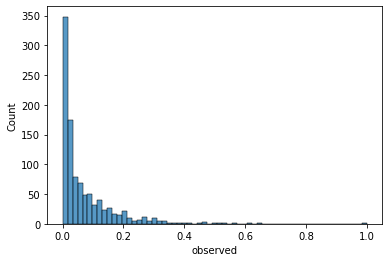

In [88]:
sns.histplot(y0_test)

In [91]:
from sklearn.metrics import mean_squared_log_error

In [95]:
def medir_error(X0_val, X0_test, X0_train, y0_val, y0_test, y0_train, best_model0, rio):
    metrica1 = mean_absolute_error #mae
    metrica2 = mean_squared_error # mse
    metrica3 = mean_squared_log_error
    nombre_metrica3 = "Error Cuadratico Medio Logaritmico"


    #Se utiliza la función predict() para generar predicciones utilizando el mejor modelo obtenido sobre los conjuntos de validación, testeo y entrenamiento
    predictions_val = best_model0.predict(X0_val)
    predictions_test = best_model0.predict(X0_test)
    predictions_train = best_model0.predict(X0_train)

    #Se calculan diferentes métricas de evaluación para las predicciones realizadas por el modelo en el conjunto de validación.
    mae_val = metrica1(y0_val, predictions_val) #se utiliza la función mean_absolute_error para calcula el error absoluto medio entre los valores reales (y_val) y las predicciones (predictions_val)
    mse_val = metrica2(y0_val, predictions_val) #se utiliza la función mean_squared_error para calcula el error cuadrático medio entre los valores reales (y_val) y las predicciones (predictions_val)
    mape_val = metrica3(y0_val, predictions_val)
    r2_val = r2_score(y0_val, predictions_val) #se utiliza la función r2_score para calcula el coeficiente de determinación (R²) entre los valores reales (y_val) y las predicciones (predictions_val)

    #Se calculan diferentes métricas de evaluación para las predicciones realizadas por el modelo en el conjunto de testeo.
    mae_test = metrica1(y0_test, predictions_test)
    mse_test = metrica2(y0_test, predictions_test)
    mape_test = metrica3(predictions_test, y0_test)
    r2_test = r2_score(y0_test, predictions_test)

    #Se calculan diferentes métricas de evaluación para las predicciones realizadas por el modelo en el conjunto de entrenamiento.
    mae_train = metrica1(y0_train, predictions_train)
    mse_train = metrica2(y0_train, predictions_train)
    mape_train = metrica3(y0_train, predictions_train)
    r2_train = r2_score(y0_train, predictions_train)
    print(f"{rio}")
    print("Conjunto de validación")
    print('Error Absoluto Medio (MAE):', round(mae_val, 3))
    print('Error Cuadrático Medio (MSE):', round(mse_val, 3))
    print(f'{nombre_metrica3}:', round(mape_val, 3))
    print('Coeficiente de determinación (R²):', round(r2_val, 3))
    sns.histplot(predictions_val - y0_val)
    plt.title('Distribución de Erores, Validación')
    plt.show()
    print("\n")

    print("Conjunto de testeo")
    print('Error Absoluto Medio (MAE):', round(mae_test, 3))
    print('Error Cuadrático Medio (MSE):', round(mse_test, 3))
    print(f'{nombre_metrica3}:', round(mape_test, 3))
    print('Coeficiente de determinación (R²):', round(r2_test, 3))
    sns.histplot(predictions_test - y0_test)
    plt.title('Distribución de Erores, Testeo')
    plt.show()
    print("\n")

    print("Conjunto de entrenamiento")
    print('Error Absoluto Medio (MAE):', round(mae_train, 3))
    print('Error Cuadrático Medio (MSE):', round(mse_train, 3))
    print(f'{nombre_metrica3}:', round(mape_train, 3))
    print('Coeficiente de determinación (R²):', round(r2_train, 3)) 
    sns.histplot(predictions_train - y0_train)
    plt.title('Distribución de Erores, Entrenamiento')
    plt.show()


Río Muco
Conjunto de validación
Error Absoluto Medio (MAE): 0.003
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.978


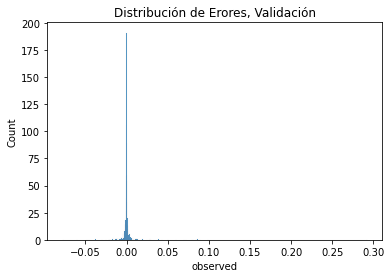



Conjunto de testeo
Error Absoluto Medio (MAE): 0.003
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.984


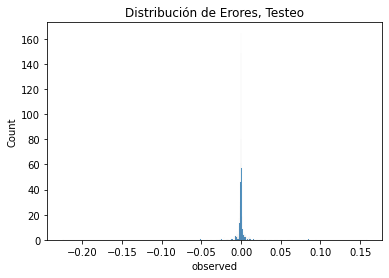



Conjunto de entrenamiento
Error Absoluto Medio (MAE): 0.002
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.995


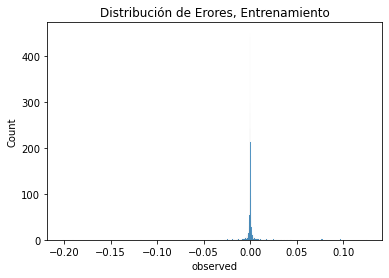

In [96]:
rio = "Río Muco"
medir_error(X0_val, X0_test, X0_train, y0_val, y0_test, y0_train, best_model0, rio)

**Río Perquilauquen En San Manuel:**

Río Perquilauquen En San Manuel:
Río Perquilauquen
Conjunto de validación
Error Absoluto Medio (MAE): 0.002
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.944


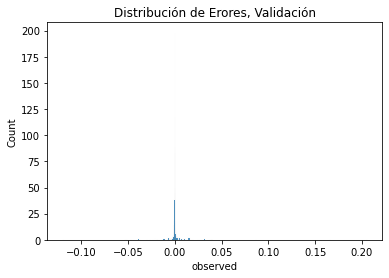



Conjunto de testeo
Error Absoluto Medio (MAE): 0.002
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.965


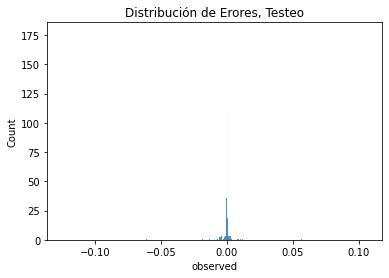



Conjunto de entrenamiento
Error Absoluto Medio (MAE): 0.001
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.975


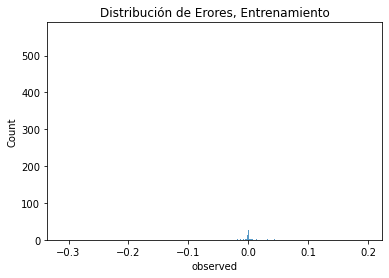

In [97]:
rio1 = "Río Perquilauquen"
print("Río Perquilauquen En San Manuel:")
medir_error(X1_val, X1_test, X1_train, y1_val, y1_test, y1_train, best_model1, rio1)

**Río Choapa En Cuncumen:**

Río Choapa En Cuncumen:
Río Choapa
Conjunto de validación
Error Absoluto Medio (MAE): 0.003
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.996


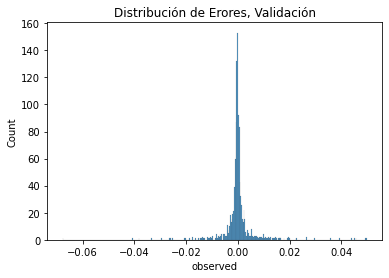



Conjunto de testeo
Error Absoluto Medio (MAE): 0.003
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.995


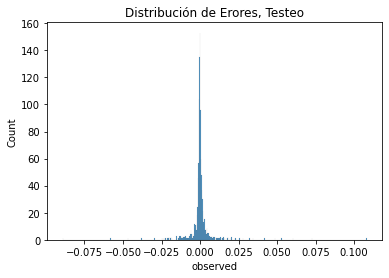



Conjunto de entrenamiento
Error Absoluto Medio (MAE): 0.002
Error Cuadrático Medio (MSE): 0.0
Error Cuadratico Medio Logaritmico: 0.0
Coeficiente de determinación (R²): 0.998


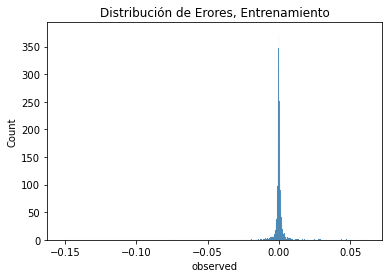

In [98]:
rio2 = "Río Choapa"
print("Río Choapa En Cuncumen:")
medir_error(X2_val, X2_test, X2_train, y2_val, y2_test, y2_train, best_model2, rio2)

In [62]:
print("Parametros Primer Caudal")
param_grid = {'n_estimators': [125], 'max_depth': [5, 10], 'min_samples_split': [10, 15], 'min_samples_leaf': [5, 10], 'max_features': ['auto','sqrt','log2']}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5 ,scoring='r2')


grid_search.fit(X1_train, y1_train)
#Se utiliza fit para ajustar y evaluar múltiples modelos de de regresión de Random Forest con diferentes combinaciones de hiperparámetros utilizando validación cruzada.

#Se obtienen los mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_ #se utiliza best_params_ para obtener los mejores valores hiperparámetros obtenidos de grid_search
best_model = grid_search.best_estimator_ #Se utiliza best_estimator_ para obtener el mejor modelo que se ajuste a los datos utilizando los mejores hiperparámetros.

print('Mejores hiperparámetros:', best_params)

#Se utiliza la función predict() para generar predicciones utilizando el mejor modelo obtenido sobre los conjuntos de validación, testeo y entrenamiento
predictions_val = best_model.predict(X1_val)
predictions_test = best_model.predict(X1_test)
predictions_train = best_model.predict(X1_train)

#Se calculan diferentes métricas de evaluación para las predicciones realizadas por el modelo en el conjunto de validación.
mae_val = mean_absolute_error(y1_val, predictions_val) #se utiliza la función mean_absolute_error para calcula el error absoluto medio entre los valores reales (y_val) y las predicciones (predictions_val)
mse_val = mean_squared_error(y1_val, predictions_val) #se utiliza la función mean_squared_error para calcula el error cuadrático medio entre los valores reales (y_val) y las predicciones (predictions_val)
r2_val = r2_score(y1_val, predictions_val) #se utiliza la función r2_score para calcula el coeficiente de determinación (R²) entre los valores reales (y_val) y las predicciones (predictions_val)

#Se calculan diferentes métricas de evaluación para las predicciones realizadas por el modelo en el conjunto de testeo.
mae_test = mean_absolute_error(y1_test, predictions_test)
mse_test = mean_squared_error(y1_test, predictions_test)
r2_test = r2_score(y1_test, predictions_test)

#Se calculan diferentes métricas de evaluación para las predicciones realizadas por el modelo en el conjunto de entrenamiento.
mae_train = mean_absolute_error(y1_train, predictions_train)
mse_train = mean_squared_error(y1_train, predictions_train)
r2_train = r2_score(y1_train, predictions_train)

print("Conjunto de validación")
print('Error Absoluto Medio (MAE):', round(mae_val, 3))
print('Error Cuadrático Medio (MSE):', round(mse_val, 3))
print('Coeficiente de determinación (R²):', round(r2_val, 3))
print("\n")
print("Conjunto de testeo")
print('Error Absoluto Medio (MAE):', round(mae_test, 3))
print('Error Cuadrático Medio (MSE):', round(mse_test, 3))
print('Coeficiente de determinación (R²):', round(r2_test, 3))
print("\n")
print("Conjunto de entrenamiento")
print('Error Absoluto Medio (MAE):', round(mae_train, 3))
print('Error Cuadrático Medio (MSE):', round(mse_train, 3))
print('Coeficiente de determinación (R²):', round(r2_train, 3))


Parametros Primer Caudal


KeyboardInterrupt: 

In [ ]:
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Conjunto de validación
Error Absoluto Medio (MAE): 0.015
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.829


Conjunto de testeo
Error Absoluto Medio (MAE): 0.015
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.842


Conjunto de entrenamiento
Error Absoluto Medio (MAE): 0.007
Error Cuadrático Medio (MSE): 0.0
Coeficiente de determinación (R²): 0.972


In [ ]:
Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}

Conjunto de validación
Error Absoluto Medio (MAE): 0.015
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.829


Conjunto de testeo
Error Absoluto Medio (MAE): 0.016
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.843


Conjunto de entrenamiento
Error Absoluto Medio (MAE): 0.01
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.933

In [ ]:
Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 125}

Conjunto de validación
Error Absoluto Medio (MAE): 0.016
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.827


Conjunto de testeo
Error Absoluto Medio (MAE): 0.016
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.84


Conjunto de entrenamiento
Error Absoluto Medio (MAE): 0.011
Error Cuadrático Medio (MSE): 0.001
Coeficiente de determinación (R²): 0.93